In [1]:
import pandas as pd
import numpy as np
import io
import requests
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# zaczytywanie pliku
url = 'https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv'
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('ISO-8859-1')))

In [3]:
df.head(2)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0


In [4]:
# Input variables:
# ID -	Unique ID (can not be used for predictions)
# Gender-	Sex
# City -	Current City
# Monthly_Income - Monthly Income in rupees
# DOB -	Date of Birth
# Lead_Creation_Date -	Lead Created on date
# Loan_Amount_Applied -	Loan Amount Requested (INR)
# Loan_Tenure_Applied -	Loan Tenure Requested (in years)
# Existing_EMI -	EMI of Existing Loans (INR)
# Employer_Name - Employer Name
# Salary_Account- Salary account with Bank
# Mobile_Verified - Mobile Verified (Y/N)
# Var5- Continuous classified variable
# Var1- Categorical variable with multiple levels
# Loan_Amount_Submitted- Loan Amount Revised and Selected after seeing Eligibility
# Loan_Tenure_Submitted-	Loan Tenure Revised and Selected after seeing Eligibility (Years)
# Interest_Rate-	Interest Rate of Submitted Loan Amount
# Processing_Fee- Processing Fee of Submitted Loan Amount (INR)
# EMI_Loan_Submitted- EMI of Submitted Loan Amount (INR), EMI = Equated monthly installment
# Filled_Form- Filled Application form post quote
# Device_Type- Device from which application was made (Browser/ Mobile)
# Var2- Categorical Variable with multiple Levels
# Source-	Categorical Variable with multiple Levels
# Var4-	Categorical Variable with multiple Levels

In [5]:
# Zgodnie z instrukcją zadania usuwam z DataFrame kolumnę LoggedIn
df = df.drop('LoggedIn',axis=1)

max wiek:  100 
 min wiek:  18


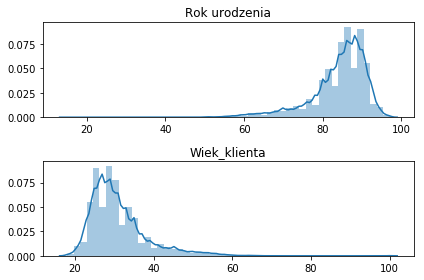

In [7]:
# Z kolumny DOB wyciągamy informację dotyczącu roku urodzenia naszego klienta, wartość może przydać się do modelowania
# sprawdzamy czy daty urodzenia są realne, z perspektywy roku 2015 - rok w którym jest wnioskowanie o pożyczkę
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

rok_urodzenia = [int(x.split('-')[2]) for x in  df['DOB']]
sns.distplot(rok_urodzenia, ax= ax1).set_title('Rok urodzenia')

wiek = [2015 - (1900 + x) for x in rok_urodzenia]
sns.distplot(wiek, ax = ax2).set_title('Wiek_klienta')

print('max wiek: ', max(wiek), '\n','min wiek: ', min(wiek)) 
# po wyniku max i min widoczne, że dane prawdopodobnie zostały sztucznie spreparowane                                                     

df['wiek_klienta'] = rok_urodzenia


fig.tight_layout() # funkcja robi ładne odstępy pięszy wykresami
plt.show()

#klienci w naszym pliku mają wiek maksymalnie 100 lat (urodzieni w roku 15) i minimalnie 18 lat (rok 97)

In [8]:
# z df wyciągamy wszytskie dane numeryczne ciągłe, żeby zobaczyć czy zachodzą międzu nimi korelacje liniowe
numeryczne = ['Monthly_Income','Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI', 'Var5', 'Loan_Amount_Submitted',\
             'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee', 'EMI_Loan_Submitted', 'wiek_klienta']

# sns.pairplot(df[numeryczne])

In [9]:
# z powyższej macierzy wykresów można zaobserwować relacje pomiędzy kwotą wnioskowania a liczbą rat,
# widać również liniowe odcięcie poniżej którego wartości nie występują dla wykresu pokazującego
# relację ilości rat (EMI_loan_submitted) vs. opłatą manipulacyjną (processing_fee)
# odnośnie nowej wieku, który dodałam jako dodatkową zmienną widać, że ma on znaczenie we wnioskowanej kwocie pożyczki
# im starszy klient tym szerszy zakres wnioskowanych kwot o pożyczkę

In [11]:
# w kolejnym kroku zajmujemy się kolumnami numerycznymi zawierającymi NA
# zbudujemy funkcję do badanie kolumn kategorycznych i numerycznych
# funkcja jako zmienne przyjmuje dataframe, wektor kolumn numerycznych/ kategorycznych oraz kategorię numercyczne/ kategoryczne
# dla kolumn numerycznych zwraca: nazwę kolumny, inf. o ilości wartości NA, % wartości NA vs wszytstkie wartości,
# średnią, medianę oraz percentyle
# dla kolumn kategorycznych zwraca inf. o ilości wartości NA, % wartości NA vs wszytstkie wartości,
# oraz informację ile jest kategorii
def sprawdzanie_NA_value(df, kolumny, rodzaj):
    liczba_rekordów = df.shape[0]
    lista = []
    kolumny_na= ['nazwa' ,'ile_NA', 'proc_NA','percentyl_10','mediana', 'percentyl_90', 'średnia' ]
    if rodzaj == 'kategoryczne':
        kolumny_na= ['nazwa' ,'ile_NA', 'proc_NA','#unikalne_kategorie', 'unikalne_kategorie' ]
    df_na = pd.DataFrame(['' for i in range(len(kolumny_na))]).T        

    for kolumna in kolumny:
        df_ = df[kolumna]
        ile_na = liczba_rekordów - df_.isna().shape[0]
        proc_na = str(np.round((ile_na/liczba_rekordów)*100,0))+'%'
        df_.dropna(inplace = True)
        if rodzaj == 'numeryczne':
            percentyl_10 = np.round(np.percentile(df_,10),0)
            mediana = np.round(np.percentile(df_,50),0)
            percentyl_90 = np.round(np.percentile(df_,90),0)
            srednia = np.round(np.mean(df_),0)
            for element in [kolumna ,ile_na, proc_na,percentyl_10, mediana, percentyl_90, srednia ]:
                lista.append(element)
        else:
            ile_unikalnych_kategorii = len(df_.unique())
            unikalne_kategorie = df_.unique()
            for element in [kolumna ,ile_na, proc_na, ile_unikalnych_kategorii, unikalne_kategorie ]:
                lista.append(element)            
        df_na_temp = pd.DataFrame(lista).T
        df_na = pd.concat([df_na,df_na_temp])
        lista = []    

    df_na.rename(columns = {i:j for i,j in zip(range(len(kolumny_na)), kolumny_na)}, inplace = True)    
    df_na = df_na.reset_index().drop('index', axis =1).drop(0)
    return df_na
df_na = sprawdzanie_NA_value(df, numeryczne, 'numeryczne')
df_na

,nazwa,ile_NA,proc_NA,percentyl_10,mediana,percentyl_90,średnia
1,Monthly_Income,0,0.0%,12000,25000,62000,58850
2,Loan_Amount_Applied,71,0.0%,0,100000,500000,230251
3,Loan_Tenure_Applied,71,0.0%,0,2,5,2
4,Existing_EMI,71,0.0%,0,0,10000,3696
5,Var5,0,0.0%,0,2,14,5
6,Loan_Amount_Submitted,34613,40.0%,100000,300000,800000,395011
7,Loan_Tenure_Submitted,34613,40.0%,2,4,5,4
8,Interest_Rate,59294,68.0%,14,18,32,19
9,Processing_Fee,59600,68.0%,1200,4000,10000,5131
10,EMI_Loan_Submitted,59294,68.0%,4102,9393,19151,11000


In [10]:
# w niektórych kolumnach jest bardzo dużo wartości NA, dlatego należy rozważyć zastąpienie ich średnią albo medianą,
# wybieram medianę ponieważ przyjmuje mniejsze wartości od średniej, 
# nie chce, żeby wartości odstające wpływały bardzo na analizę 
for nazwa, mediana in zip(df_na['nazwa'],df_na['mediana']):
    df.update(df[nazwa].fillna(mediana))

In [11]:
# sprawdzam, czy wszystkie NA zostały zastąpione medianą
sprawdzanie_NA_value(df, numeryczne,'numeryczne')

,nazwa,ile_NA,proc_NA,percentyl_10,mediana,percentyl_90,średnia
1,Monthly_Income,0,0.0%,12000,25000,62000,58850
2,Loan_Amount_Applied,0,0.0%,0,100000,500000,230144
3,Loan_Tenure_Applied,0,0.0%,0,2,5,2
4,Existing_EMI,0,0.0%,0,0,10000,3693
5,Var5,0,0.0%,0,2,14,5
6,Loan_Amount_Submitted,0,0.0%,140000,300000,560000,357219
7,Loan_Tenure_Submitted,0,0.0%,3,4,5,4
8,Interest_Rate,0,0.0%,16,18,20,18
9,Processing_Fee,0,0.0%,2500,4000,5400,4356
10,EMI_Loan_Submitted,0,0.0%,7271,9393,11781,9905


In [12]:
# za pomocą wcześniej napisanej funkcjisprawdzam teraz zmienne kategoryczne pod kątem ilości wartości NA, 
# usuwam ze zbioru kolumn kolumny, które analizowaliśmy wcześniej jako kolumny numeryczne, 
# usuwam również imię pracownika, numer ID oraz daty
kategoryczne = df.drop(numeryczne, axis =1).keys()[:-1].drop(['DOB', 'Lead_Creation_Date', 'Employer_Name','ID'])
kategoryczne

sprawdzanie_NA_value(df,kategoryczne,'kategoryczne')

,nazwa,ile_NA,proc_NA,#unikalne_kategorie,unikalne_kategorie
1,Gender,0,0.0%,2,"[Female, Male]"
2,City,0,0.0%,697,"[Delhi, Mumbai, Panchkula, Saharsa, Bengaluru,..."
3,Salary_Account,0,0.0%,57,"[HDFC Bank, ICICI Bank, State Bank of India, H..."
4,Mobile_Verified,0,0.0%,2,"[N, Y]"
5,Var1,0,0.0%,19,"[HBXX, HBXA, HAXM, HAXB, HBXC, HBXD, HBXH, HAX..."
6,Filled_Form,0,0.0%,2,"[N, Y]"
7,Device_Type,0,0.0%,2,"[Web-browser, Mobile]"
8,Var2,0,0.0%,7,"[G, B, C, E, F, D, A]"
9,Source,0,0.0%,30,"[S122, S143, S134, S133, S159, S151, S137, S12..."
10,Var4,0,0.0%,8,"[1, 3, 5, 4, 2, 7, 6, 0]"


In [13]:
kolumny = kategoryczne
liczba_rekordów = df.shape[0]
lista = []
kolumny_na= ['nazwa' ,'ile_na', 'proc_na','percentyl_10','mediana', 'percentyl_90', 'średnia' ]
if len(kolumny) == len(numeryczne):
    df_na = pd.DataFrame(['' for i in range(6)]).T
else:
    kolumny_na = kolumny_na[:2]
    df_na = pd.DataFrame(['' for i in range(2)]).T    \
        
df_na

,0,1
0,,


In [14]:
kolumny_na= ['nazwa' ,'ile_na', 'proc_na','percentyl_10','mediana', 'percentyl_90', 'średnia' ]
kolumny_na = kolumny_na[:4]
df_na = pd.DataFrame(['' for i in range(4)]).T
df_na

,0,1,2,3
0,,,,


In [15]:

# najpierw sprawdzam czy % wniosków dla klientów, którzy otrzymali pożyczkę jest znaczący - gdyby nie był model
# mógłby dawać wysoki wynik przy niskiej faktycznie skuteczności

print('procent wniosków z udzieloną pożyczką: ',str(np.round(((df[df['Disbursed']==1].size/df.size)*100),1))+'%')

procent wniosków z udzieloną pożyczką:  1.5%


In [16]:
df.size

2262520

In [17]:
df[df['Disbursed']==1].size

33098